# Анализ поведения пользователей мобильного приложения

**Цель исследования:**
 
 Необходимо разобраться, как ведут себя пользователи  мобильного приложения , запустить A/A/B-тест на предмет изменения шрифта во всём приложениии и проанализировать результаты.
 
**Исходные данные:**

логи пользователей мобильного приложения (/datasets/logs_exp.csv): 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
 

**Ход исследования:**
 1) Обзор, подготовка и предобработка данных;
 
 2) Анализ данных;
 
 3) Воронка событий;
 
 4) Анализ результатов A/A/B-теста;
 
 5) Общий вывод.
 

## Обзор, подготовка и предобработка данных

### Обзор данных

In [1]:
# импортируем библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
# снимаем ограничение на количество столбцов
pd.set_option('display.max_colwidth', None)
# игнорируем предупреждения
pd.set_option('chained_assignment', None)  
import warnings
warnings.filterwarnings(action = 'ignore') 
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
# Отображение числовых данных в читаемом виде
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# открываем файлы 
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
    
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [3]:
## Выведем общую инфо 
print(f'Файл с данными о логах пользователей мобильного приложения {df.shape[0]} строк в {df.shape[1]} столбцах.')

Файл с данными о логах пользователей мобильного приложения 244126 строк в 4 столбцах.


In [4]:
## Получим более детальную инфо по датасету
display(df.head())
print('*'*100)
print('Количество пропусков =',df.isna().sum())
print('*'*100)
df.info()
print('Количество дубликатов =', df.duplicated().sum(), ',что составляет', round(df.duplicated().sum()/len(df)*100,2), '%')
print('*'*100)
display(df.columns)
print('*'*100)
display(df.describe())
print()
    

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


****************************************************************************************************
Количество пропусков = EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Количество дубликатов = 413 ,что составляет 0.17 %
****************************************************************************************************


Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

****************************************************************************************************


,DeviceIDHash,EventTimestamp,ExpId
count,244126.00,244126.00,244126.00
mean,4627568124591259648.00,1564913915.84,247.02
std,2642424998963707904.00,177134.32,0.82
min,6888746892508752.00,1564029816.00,246.00
25%,2372212476992240640.00,1564756580.25,246.00
50%,4623191541214045184.00,1564919395.00,247.00
75%,6932517045703054336.00,1565074511.00,248.00
max,9222603179720523776.00,1565212517.00,248.00


**Вывод по п.1.1**

1. Файл с данными о логах пользователей мобильного приложения 244126 строк в 4 столбцах;

2. Пропуски отсутствуют;

3. Количество дубликатов = 413,что составляет 0.17 %;

4. Необходимо привести к нижнему регистру наименования столбцов ('EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'); 

5. Необходимо поменять тип данных в столбце EventTimestamp	 с object на datetime и добавить отдельный столбец дат.



### Подготовка данных

**Замена названия столбцов**

In [5]:
df = df.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'date_time', 'ExpId': 'group_id'})
print(df.columns)

Index(['event', 'user_id', 'date_time', 'group_id'], dtype='object')


**Приведение данных к необходимому формату и добавление отдельного столбца с датами**

In [6]:
# Замена типа данных в столбце date_time с object на datetime (т.к. значения времени в столбце date_time представлены в секундах, добавим unit='s') )
df['date_time'] = pd.to_datetime(df['date_time'], unit='s')

In [7]:
# добавим отдельный столбец дат
df['dt'] = pd.to_datetime(df['date_time']).dt.date 
df.sample()

,event,user_id,date_time,group_id,dt
108710,MainScreenAppear,1265055052971587352,2019-08-04 03:19:33,246,2019-08-04


**Пропуски и дубликаты**

Пропуски в файле отсутствуют.

Количество дубликатов = 413,что составляет 0.17 %. Удалим дубликаты.

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

**Прочие проверки**

In [9]:
# Дополнительно проверим, есть ли пересечения пользователей в группах
print('Количество пользователей, попадающих в несколько групп:',
(
df
    .groupby('user_id')
    .agg({'group_id' : 'nunique'})
    .query('group_id>1')
    .count()
))

Количество пользователей, попадающих в несколько групп: group_id    0
dtype: int64


**Вывод по п.1.2**
1) Названия столбцов приведены к нижнему регистру;

2) Данные о времени приведены к формату datetime, добавлен отдельный столбец дат;

3) Пропуски в данных отсутствуют; были удалены явные дубликаты (413 единиц), что составляло менее 1% от общего количества;


4) Пользователи, присутствующие одновременно в нескольких группах, отсутствуют.


## Анализ данных

### Количество событий, пользователей в логе

In [10]:
print(df['event'].value_counts())
print('Всего уникальных событий:', len(df['event'].unique()))

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64
Всего уникальных событий: 5


In [11]:
print(f'Всего событий в логе: {len(df)}')
print(f'Всего пользователей в логе: {df["user_id"].nunique()}')
print(f'Среднее количество событий, приходящихся на пользователя: {round(len(df)/df["user_id"].nunique(),1)}')
print(f'Медианное количество событий, приходящихся на пользователя: {round(df.groupby("user_id")["event"].count().median(),1)}')

Всего событий в логе: 243713
Всего пользователей в логе: 7551
Среднее количество событий, приходящихся на пользователя: 32.3
Медианное количество событий, приходящихся на пользователя: 20.0


Разница между средним и медианным количеством событий существенна, - скорее всего, есть выбросы. Построим гистограмму и оценим визуально.

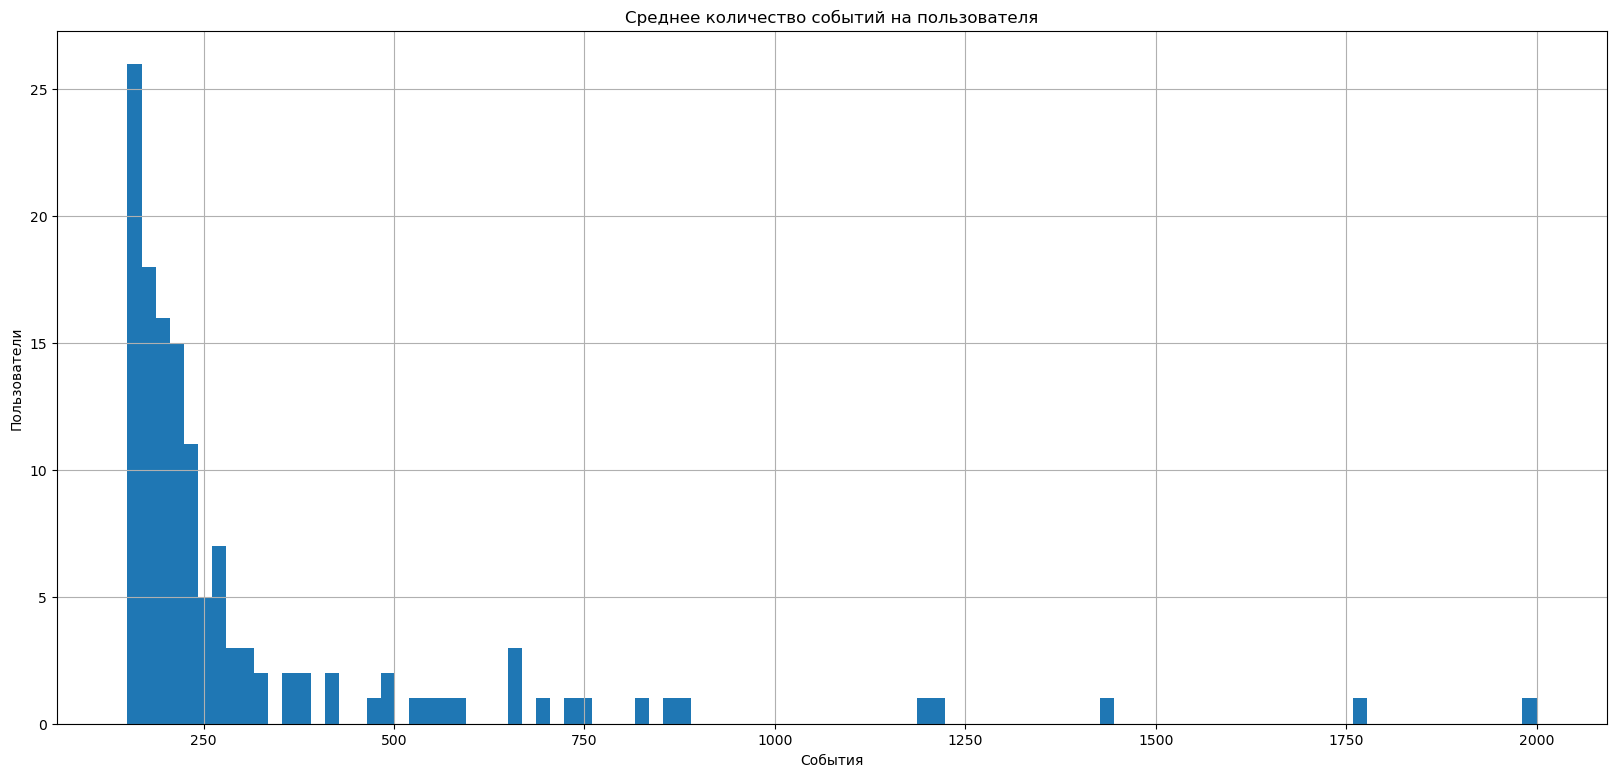

In [12]:
# Построим гистограмму
plt.figure(figsize=(20,9))
plt.hist(df.groupby("user_id")["event"].count(), bins=100, range=(150,2000))
plt.xlabel('События')
plt.ylabel('Пользователи')
plt.grid()
plt.title('Среднее количество событий на пользователя')
plt.show()

Действительно, на гистограмме видны выбросы, более корректно проводить оценку по медианному количеству событий, приходящихся на пользователя: 20.0.

### Период времени

In [13]:
df['date_time'].describe().T

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object

In [14]:
print('В логе присутствуют данные с ', df['date_time'].min(), ' (минимальная дата), по ', df['date_time'].max(), '(максимальная дата).')
print(f'Период: {df["date_time"].max() - df["date_time"].min()}')

В логе присутствуют данные с  2019-07-25 04:43:36  (минимальная дата), по  2019-08-07 21:15:17 (максимальная дата).
Период: 13 days 16:31:41


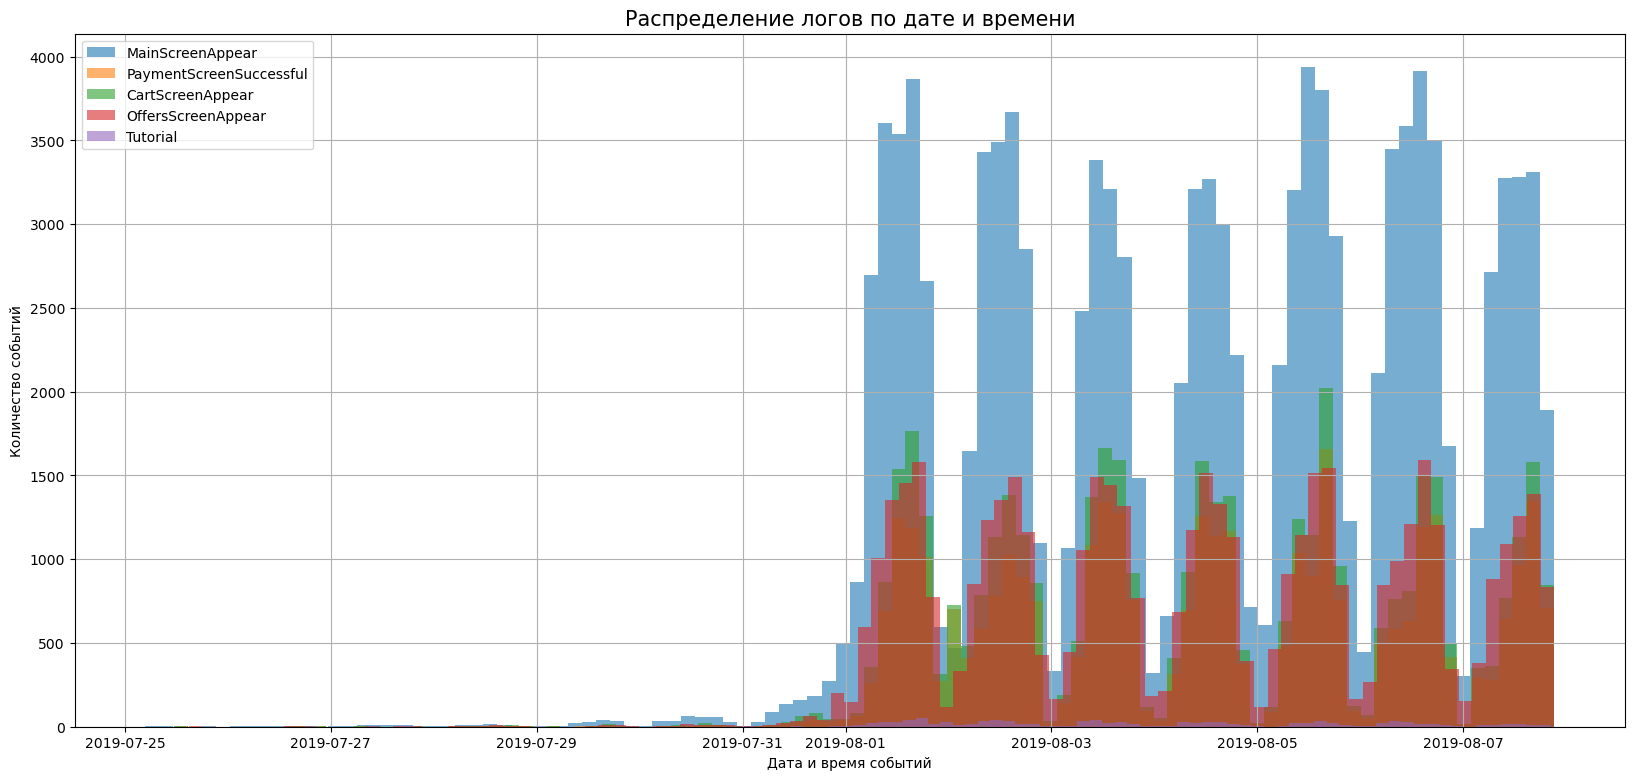

In [15]:
# Строим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп
# Создаем группы событий
event_groups = df['event'].unique()

plt.figure(figsize=(20,9))

# Для каждой группы событий строим гистограмму с соответствующим цветом
for i, event in enumerate(event_groups):
    plt.hist(df[df['event'] == event]['date_time'], bins=100, alpha=0.6, color=plt.cm.tab10(i), label=event)

plt.title('Распределение логов по дате и времени', fontsize=15)
plt.xlabel('Дата и время событий')
plt.grid()
plt.ylabel('Количество событий')
plt.legend()
plt.show()

Мобильным приложением стали активно пользоваться в промежуток времени между 2019-07-31 и 2019-08-01. Приблизим гистограмму, выбрав указанный  временной промежуток, чтобы опеределиться с минимальной границей.

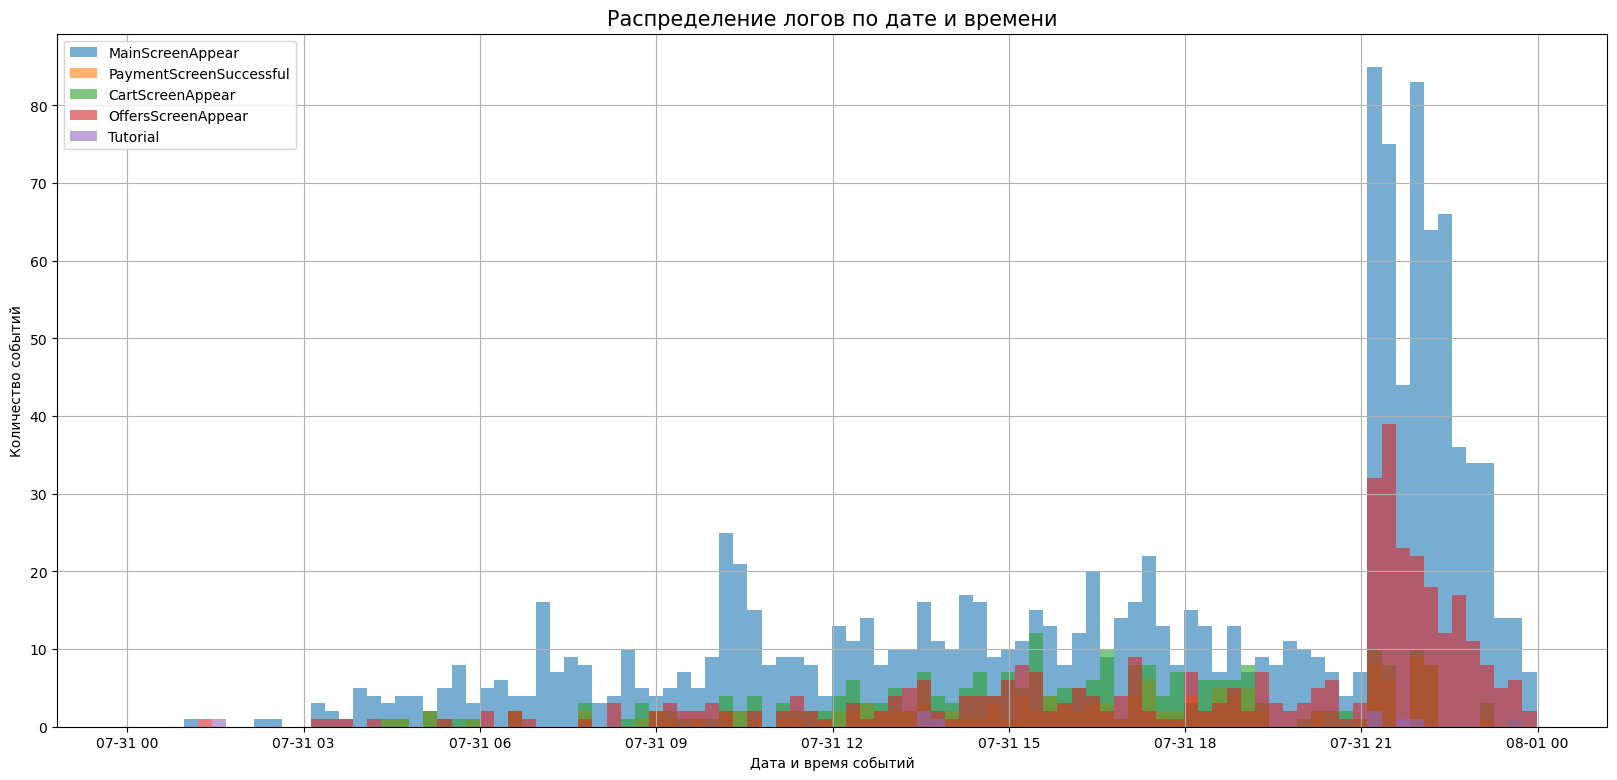

In [16]:
plt.figure(figsize=(20,9))

# Для каждой группы событий строим гистограмму с соответствующим цветом
for i, event in enumerate(event_groups):
    plt.hist(df[df['event'] == event]['date_time'], bins=100, alpha=0.6, range=('2019-07-31 00:00:00','2019-07-31 23:59:00'),color=plt.cm.tab10(i), label=event)

plt.title('Распределение логов по дате и времени', fontsize=15)
plt.xlabel('Дата и время событий')
plt.grid()
plt.ylabel('Количество событий')
plt.legend()
plt.show()

По диаграмме можно предположить, что события, совершенные 31 июля, это события из прошлого, которые "доезжают" и  могут искажать данные.
Определим временной интервал для целей анализа: с 01 августа по 07 августа.

### Определение потери данных при  актуализации временного периода

In [17]:
print('До актуализации временного периода всего событий:',df.shape[0] , ', всего пользователей:', df.user_id.nunique())
df_filtered= df.query('date_time >= "2019-08-01" ')
print('После актуализации временного периода всего событий:',df_filtered.shape[0] , ', всего пользователей:',df_filtered.user_id.nunique())
print('Потеря событий составила:',round((df_filtered.shape[0]/df.shape[0]-1)*100,2),'%')
print('Потеря пользователей составила:',round((df_filtered.user_id.nunique()/df.user_id.nunique()-1)*100,2),'%')

До актуализации временного периода всего событий: 243713 , всего пользователей: 7551
После актуализации временного периода всего событий: 240887 , всего пользователей: 7534
Потеря событий составила: -1.16 %
Потеря пользователей составила: -0.23 %


Потеря событий в размере -1.16 % и потеря пользователей -0.23 % не являются существенными.
Будем далее работать с файлом df_filtered.

### Распределение событий и пользователей по группам

In [18]:
df_filtered.groupby('group_id').agg({'user_id': 'nunique'}).reset_index()

,group_id,user_id
0,246,2484
1,247,2513
2,248,2537


В контрольных группах 246 и 247 - 2484 и 2513 уникальных пользователей соответственно, а в экспериментальной 248 -  2537. 

In [19]:
display('Количество событий по группам', df_filtered['group_id'].value_counts())

'Количество событий по группам'

248    84563
246    79302
247    77022
Name: group_id, dtype: int64

В контрольных группах 246 и 247 - 79302 и 77022  событий соответственно, а в экспериментальной 248 -  84563. 

Количество уникальных пользователей в группах в общем сопоставимо (разница +- не более 2%); количество событий отличается значительнее, но в целом разница составляет не более 9%, что допустимо. 

Экспериментальная 248 группа имеет больше всего пользователей и событий.

**Вывод по п.2:**

Всего событий в логе: **243 713**.
Всего 5 уникальных событий: 
* MainScreenAppear (Открытие главного экрана); 
* OffersScreenAppear (Предложения экрана);
* CartScreenAppear (Добавление товара в корзину);
* PaymentScreenSuccessful (Экран с подтверждением оплаты);
* Tutorial (Руководство).       

Всего пользователей в логе: **7551**.

Среднее количество событий, приходящихся на пользователя: 32.3.

Медианное количество событий, приходящихся на пользователя: 20.0.
Так как в данных присутствуют  выбросы, более корректно проводить оценку по медианному количеству событий, приходящихся на пользователя: 20.0.

В логе присутствуют данные с  2019-07-25 04:43:36  (минимальная дата), по  2019-08-07 21:15:17 (максимальная дата).
После построения столбчатой диаграммы был определен временной интревал для целей анализа: с **01 августа** по **07 августа**.

Потеря событий в размере -1.16 % и потеря пользователей -0.23 % не являются существенными.

Количество уникальных пользователей в группах в общем сопоставимо (разница +- не более 2%); количество событий отличается значительнее, но в целом разница составляет не более 9%, что допустимо.

Экспериментальная 248 группа имеет больше всего пользователей и событий.

## Воронка событий

### Распределение событий в логе

In [20]:
events = (df_filtered.
          groupby('event').
          agg({'user_id': 'count'}).
          reset_index().
          rename(columns={'user_id' : 'total_events'}).
          sort_values(by='total_events', ascending=False))
print(events)
print('Всего уникальных событий:', len(events))

                     event  total_events
1         MainScreenAppear        117328
2       OffersScreenAppear         46333
0         CartScreenAppear         42303
3  PaymentScreenSuccessful         33918
4                 Tutorial          1005
Всего уникальных событий: 5


Всего уникальных событий: 5. Список событий в логе (в порядке убывания): 
* MainScreenAppear (Открытие главного экрана); 
* OffersScreenAppear (Предложения экрана);
* CartScreenAppear (Добавление товара в корзину);
* PaymentScreenSuccessful (Экран с подтверждением оплаты);
* Tutorial (Руководство).

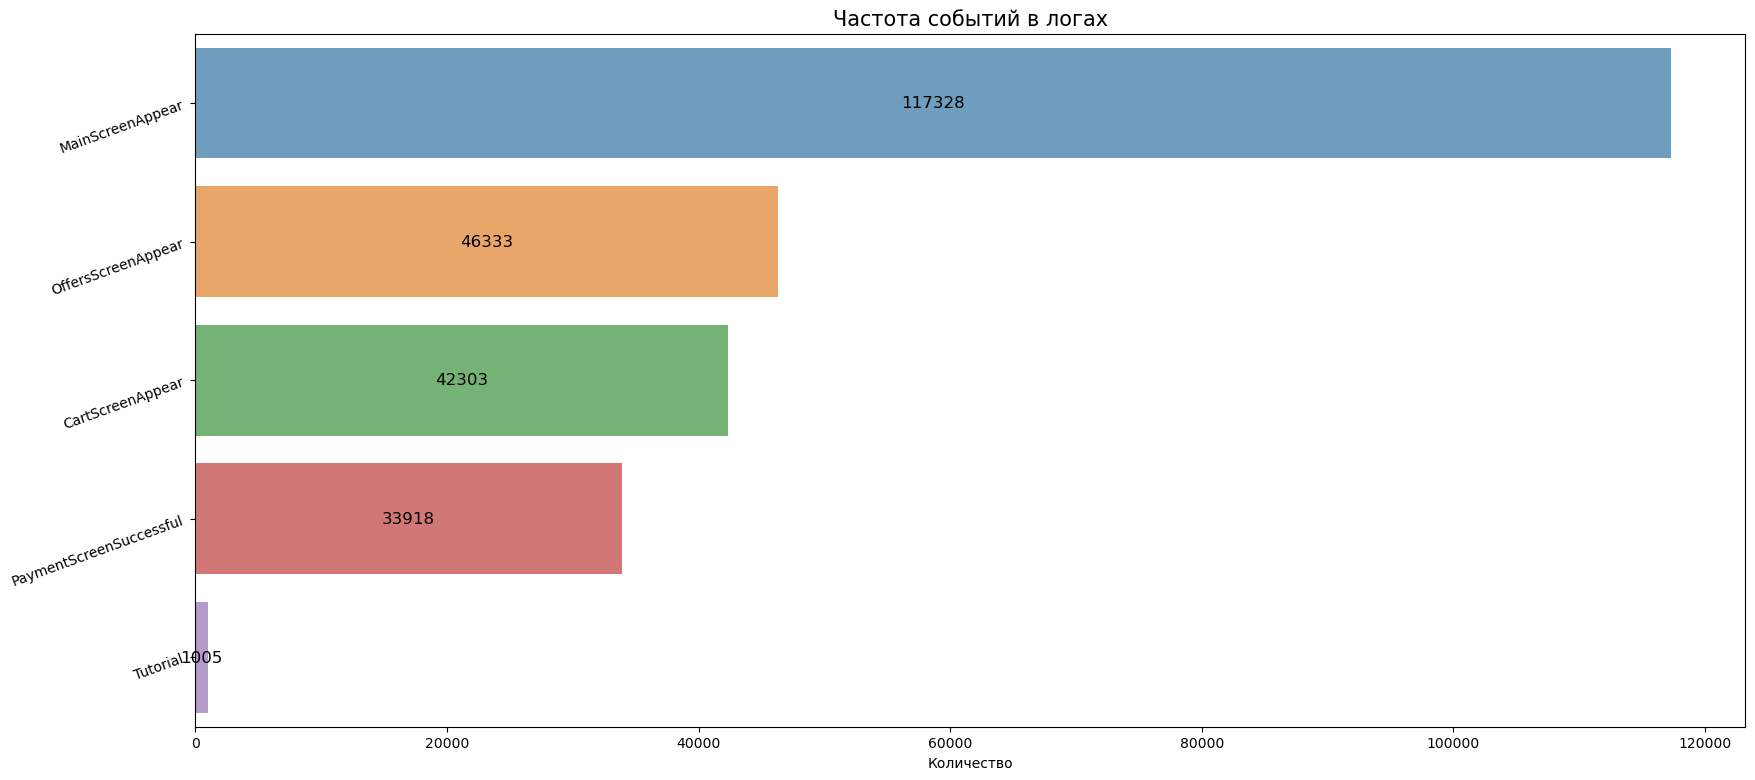

In [21]:
# Представим распределение событий в логе на диаграмме
plt.figure(figsize=(20, 9))
ax = sns.barplot(x='total_events', y='event', data=events, alpha=0.7, orient='h')
ax.set_title('Частота событий в логах', fontsize=15)
ax.set_xlabel('Количество') 
ax.set_ylabel('') 

# Добавляем подписи внутрь значений
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_x(), p.get_y()
    ax.text(x + width/2, y + height/2, f'{width:.0f}', ha='center', va='center', fontsize=12, color='black')
ax.set_yticklabels(ax.get_yticklabels(), rotation=20)
plt.show()


### Распределение пользователей по событиям и группам в логе

In [22]:
df_users=(df_filtered.groupby('event')
               .agg(group_count=('group_id', 'count'), total_users=('user_id', 'nunique'))
               .reset_index()
               .sort_values(by='group_count', ascending=False))
df_users['%_of_users'] = round(100*df_users['total_users'] / df_filtered['user_id'].nunique(),1)
df_users


,event,group_count,total_users,%_of_users
1,MainScreenAppear,117328,7419,98.50
2,OffersScreenAppear,46333,4593,61.00
0,CartScreenAppear,42303,3734,49.60
3,PaymentScreenSuccessful,33918,3539,47.00
4,Tutorial,1005,840,11.10


Посмотрим  распределение пользователей по событиям и группам в логе.

In [23]:
funnel = (df_filtered
          .groupby(['event', 'group_id'])
          .agg(n_events=('event', 'count'), total_users=('user_id', 'nunique'))
          .sort_values(by=['group_id','total_users'], ascending=False)
          .reset_index()
         )

# Зададим группы пользователей
a_users = df[df['group_id']==246]['user_id'].nunique()
b_users = df[df['group_id']==247]['user_id'].nunique()
c_users = df[df['group_id']==248]['user_id'].nunique()

    
# Функция для расчета доли  пользователей по событиям и группам в логе
def users_group(row):
    if row['group_id']==246:
        return (row['total_users'] / a_users * 100)
    elif row['group_id']==247:
        return (row['total_users'] / b_users * 100)
    elif row['group_id']==248:
        return (row['total_users'] / c_users * 100)
    
    
    
# Добавим столбец с процентом пользователей, перешедших на данный шаг
funnel['%%'] = round(funnel.apply(users_group, axis=1),1)

funnel


,event,group_id,n_events,total_users,%%
0,MainScreenAppear,248,40562,2493,98.10
1,OffersScreenAppear,248,16387,1531,60.20
2,CartScreenAppear,248,15179,1230,48.40
3,PaymentScreenSuccessful,248,12085,1181,46.50
4,Tutorial,248,350,279,11.00
5,MainScreenAppear,247,39090,2476,98.30
6,OffersScreenAppear,247,15179,1520,60.30
7,CartScreenAppear,247,12434,1238,49.10
8,PaymentScreenSuccessful,247,9981,1158,46.00
9,Tutorial,247,338,283,11.20


При распределении пользователей по событиям и группам в логе, также, как и при общем распределении событий, очередность порядка событий (в порядке убывания) идентичная:
 
* MainScreenAppear (Открытие главного экрана); 
* OffersScreenAppear (Предложения экрана);
* CartScreenAppear (Добавление товара в корзину);
* PaymentScreenSuccessful (Экран с подтверждением оплаты);
* Tutorial (Руководство).

В таблицу для построения воронки событий я добавила столбец "%%", отражающий процент пользователей, перешедших на данный шаг, от общего числа пользователей в каждой группе.



### Определение очередности событий

Посмотрим, в каком порядке происходят события и все ли они выстраиваются в последовательную цепочку. Возможно, какое-то событие нужно исключить при анализе воронки.

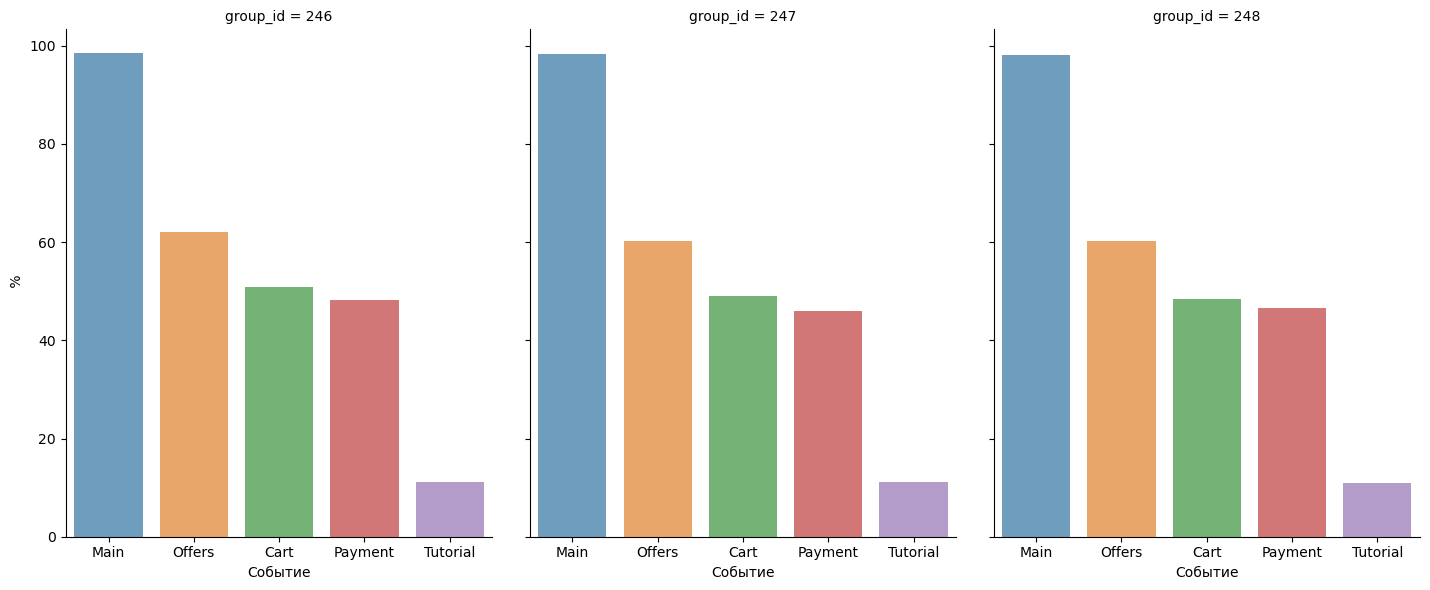

In [24]:
priority = (
    sns
    .catplot(y="%%", x="event",col="group_id",data=funnel, kind="bar",alpha=0.7,aspect=0.8,
                  height=6).set_xlabels('Событие')
    .set_ylabels(' %')
    .set_xticklabels(["Main", "Offers", "Cart", "Payment", "Tutorial"])
);

Во всех группах последовательность событий одинаковая. Для дальнейшего расчёта воронки уберем событие Tutorial(Руководство), выполнение которого не является обязательным для покупки товаров.

Таким образом, воронка событий будет состоять из следующих пунктов:
* MainScreenAppear (Открытие главного экрана); 
* OffersScreenAppear (Предложения экрана);
* CartScreenAppear (Добавление товара в корзину);
* PaymentScreenSuccessful (Экран с подтверждением оплаты);



### Воронка событий

Для расчета воронки событий модернизируем ранее полученную таблицу df_users путем добавления столбца с расчетом конверсии (какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)).

In [25]:
df_users['rate_next_step'] = round(100*df_users['total_users'] /  df_users['total_users'].shift(),1)
df_users = df_users.query('event != "Tutorial"').fillna(100).reset_index(drop=True)
df_users

,event,group_count,total_users,%_of_users,rate_next_step
0,MainScreenAppear,117328,7419,98.50,100.00
1,OffersScreenAppear,46333,4593,61.00,61.90
2,CartScreenAppear,42303,3734,49.60,81.30
3,PaymentScreenSuccessful,33918,3539,47.00,94.80


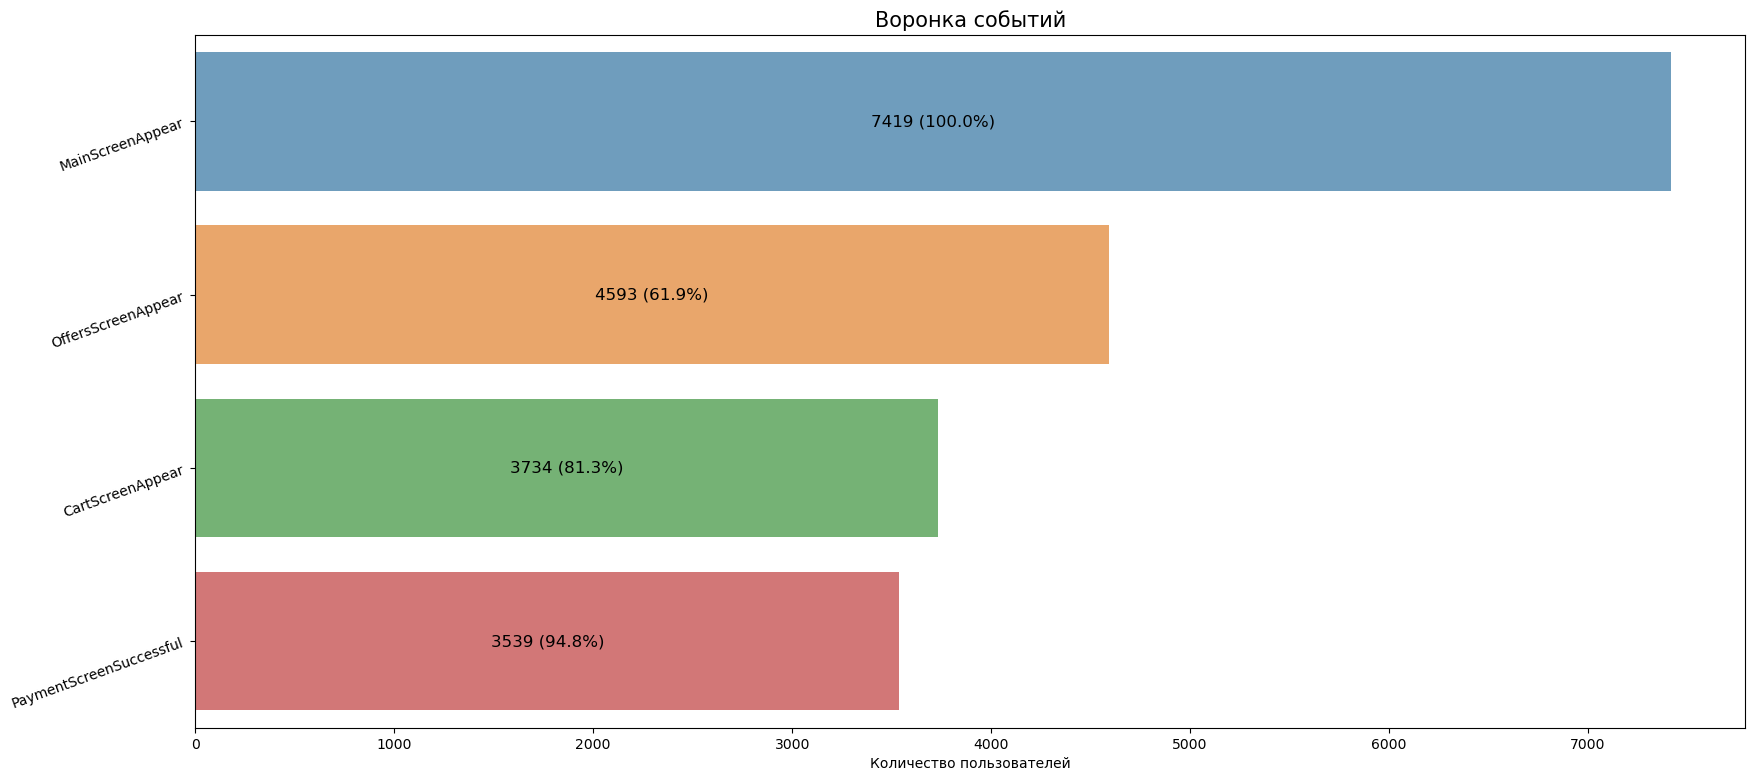

In [26]:
# Представим воронку  событий на диаграмме
plt.figure(figsize=(20, 9))
ax = sns.barplot(x='total_users', y='event', data=df_users, alpha=0.7, orient='h')
ax.set_title('Воронка событий', fontsize=15)
ax.set_xlabel('Количество пользователей')
ax.set_ylabel('')

# Вычисляем процентное соотношение относительно предыдущего значения
prev_value = None
for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_x(), p.get_y()
    
    # Вычисляем процентное соотношение
    if prev_value is None:
        percentage = 100
    else:
        percentage = 100 * width / prev_value
        
    ax.text(x + width/2, y + height/2, f'{width:.0f} ({percentage:.1f}%)', ha='center', va='center', fontsize=12, color='black')
    
    prev_value = width

ax.set_yticklabels(ax.get_yticklabels(), rotation=20)
plt.show()


Наибольшее количество пользователей теряется на втором шаге "Предложения экрана" (около 38%). 

От первого события до оплаты доходит 47 % (см. таблицу df_users, колонка "%_of_users").

**Вывод по п.3:**

Всего уникальных событий: 5. Список событий в логе (в порядке убывания): 
* MainScreenAppear (Открытие главного экрана); 
* OffersScreenAppear (Предложения экрана);
* CartScreenAppear (Добавление товара в корзину);
* PaymentScreenSuccessful (Экран с подтверждением оплаты);
* Tutorial (Руководство).

**Количество пользователей, которые совершили событие хотя бы раз:**
* Открытие главного экрана - 7419; 
* Предложения экрана - 4593;
* Добавление товара в корзину - 3734 ;
* Экран с подтверждением оплаты - 3539 ;
* Руководство - 840.

Во всех группах **последовательность событий** одинаковая:

 1) Открытие главного экрана; 
 
 2) Предложения экрана;
 
 3) Добавление товара в корзину;
 
 4) Экран с подтверждением оплаты;
 
 5) Руководство.
 
 Для дальнейшего расчёта воронки уберем событие Tutorial(Руководство), выполнение которого не является обязательным для покупки товаров.
 
 По воронке событий **доля пользователей, совершивших переход на следующий шаг воронки**:
 
 1) Открытие главного экрана - 100%; 
 
 2) Предложения экрана - 61,9%;
 
 3) Добавление товара в корзину - 81,3%;
 
 4) Экран с подтверждением оплаты - 94,8%.
 
 Наибольшее количество пользователей теряется на втором шаге "Предложения экрана" (около 38%). 

**От первого события до оплаты доходит не более 47 %.**

С учетом того, что наибольшее количество пользователей теряется на втором шаге "Предложения экрана" (около 38%), **маркетинговому отделу рекомендуется** сгенерировать и проверить гипотезы, относящиеся к дизайну главного экрана, в том числе:
* изменение описание продуктов (принцип простоты и видимости);
* увеличение кнопки Купить,чтобы пользователю проще было ее найти и нажать на нее;
* изменение визуального представления некоторых категорий продуктов.
 


## Анализ результатов A/A/B-теста

### Количество пользователей в каждой группе

In [27]:
#  Уберем событие Tutorial(Руководство), выполнение которого не является обязательным для покупки товаров
df_finish=df_filtered.query('event != "Tutorial"')

In [28]:
users_by_group=df_finish.groupby('group_id').agg({'user_id': 'nunique'}).reset_index()
users_by_group

,group_id,user_id
0,246,2483
1,247,2512
2,248,2535


В контрольных группах 246 и 247 - 2483 и 2512 уникальных пользователей соответственно, а в экспериментальной 248 -  2535. 

### Определение популярного события и долей пользователей, совершивших эти события

In [29]:
# Создаем таблицу для определения самого популярного события
by_group_event=(
    funnel
    .query('event != "Tutorial"')
    .pivot_table(index='event', columns='group_id', values='total_users', aggfunc='sum').sort_values(246, ascending=False)
)

# Добавляем столбец с суммарными данными по группам 246+247
by_group_event['246+247']=by_group_event[246]+by_group_event[247]
by_group_event['total']=by_group_event[246]+by_group_event[247]+by_group_event[248]

# Добавляем доли по событиям по каждой группе
by_group_event['246_%%'] = round(by_group_event[246]/by_group_event[246][0]*100,2)
by_group_event['247_%%'] = round(by_group_event[247]/by_group_event[247][0]*100,2)
by_group_event['248_%%'] = round(by_group_event[248]/by_group_event[248][0]*100,2)
by_group_event['246+248_%%'] = round(by_group_event['246+247']/by_group_event['246+247'][0]*100,2)
by_group_event

group_id,246,247,248,246+247,total,246_%%,247_%%,248_%%,246+248_%%
event,,,,,,,,,
MainScreenAppear,2450,2476,2493,4926,7419,100.00,100.00,100.00,100.00
OffersScreenAppear,1542,1520,1531,3062,4593,62.94,61.39,61.41,62.16
CartScreenAppear,1266,1238,1230,2504,3734,51.67,50.00,49.34,50.83
PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.98,46.77,47.37,47.87


Cамое популярное событие во всех группах - MainScreenAppear (Открытие главного экрана).

### Функция для проверки статистическими критериями разниц между выборками

Напишем функцию, которая принимает в качестве аргументов 4 числа для z-теста пропорций. 

Несколько сравнений, которые мы будем проводить на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. 

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез применим поправку Бонферрони - разделим уровень статистической значимости на количество экспериментов (16 - 4 события на 4 теста А/А(246/247), А/В 246/248, 247/248 и 246+247/248).

In [30]:
# функция для проверки статистической разницы между долями пользователей посетивших один из этапов
def z_test(sucsess1, sucsess2, trials1, trials2):

    bonferroni_alpha = 0.05/16 # для корректности применим поправку Бонферрони 
   
    
# пропорция успехов в первой группе:
    p1 = sucsess1/trials1

# пропорция успехов во второй группе:
    p2 = sucsess2/trials2

# пропорция успехов в комбинированном датасете:
    p_combined = (sucsess1 + sucsess2) / (trials1 + trials2)

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

    return p1, p2, p_value

Сформулируем нулевую и альтернативную гипотезы для попарных сравнений:
    
* **Нулевая гипотеза**: Доли пользователей на определенном этапе одинаковы в двух группах

* **Альтернативная гипотеза**: Доли пользователей на определенном этапе различны в двух группах

### A/A тест (246/247)

Перед тем как начать A/B-тестирование,можно провести A/A тест,  чтобы проверить корректность всех механизмов и расчётов.
    При отсутствии разницы между одинаковыми версиями мобильного приложения можно приступать к A/B-тестированию, который будет запущен в тех же условиях, но уже с разными вариантами шрифта. 
    

In [31]:
# создадим список из уникальных событий
events_list = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
# количество пользователей по группам 
trials1 = users_by_group.loc[users_by_group['group_id'] == 246, 'user_id'].values[0]
trials2 = users_by_group.loc[users_by_group['group_id'] == 247, 'user_id'].values[0] 
# в цикле проверим статистическую разницу между группами по каждому из этапов
for event in events_list:
    print('*'*50)
    print('Для события', event)          
    sucsess1 = by_group_event[246][event] 
    sucsess2 = by_group_event[247][event]
     
    # вызовем функцию
    p1, p2, p_value = z_test(sucsess1, sucsess2, trials1, trials2)

**************************************************
Для события MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Полученный результат в рамках А/А теста о невозможности опровержения нулевой гипотезы о равности долей тестируемых групп позволяет перейти к дальнейшему A/B-тестированию.
   


### A/C тест (246/248)

In [32]:
# количество пользователей по группам 
trials1 = users_by_group.loc[users_by_group['group_id'] == 246, 'user_id'].values[0]
trials2 = users_by_group.loc[users_by_group['group_id'] == 248, 'user_id'].values[0] 
# в цикле проверим статистическую разницу между группами по каждому из этапов
for event in events_list:
    print('*'*50)
    print('Для события', event)          
    sucsess1 = by_group_event[246][event] 
    sucsess2 = by_group_event[248][event]
     
    # вызовем функцию
    p1, p2, p_value = z_test(sucsess1, sucsess2, trials1, trials2)

**************************************************
Для события MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### B/C тест (247/248)

In [33]:
# количество пользователей по группам 
trials1 = users_by_group.loc[users_by_group['group_id'] == 247, 'user_id'].values[0]
trials2 = users_by_group.loc[users_by_group['group_id'] == 248, 'user_id'].values[0] 
# в цикле проверим статистическую разницу между группами по каждому из этапов
for event in events_list:
    print('*'*50)
    print('Для события', event)          
    sucsess1 = by_group_event[247][event] 
    sucsess2 = by_group_event[248][event]
     
    # вызовем функцию
    p1, p2, p_value = z_test(sucsess1, sucsess2, trials1, trials2)

**************************************************
Для события MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### A+B/C тест ((246+247)/248)

In [34]:
# количество пользователей по группам 
trials1 = users_by_group.loc[users_by_group['group_id'] == 246, 'user_id'].values[0]+users_by_group.loc[users_by_group['group_id'] == 247, 'user_id'].values[0]
trials2 = users_by_group.loc[users_by_group['group_id'] == 248, 'user_id'].values[0] 
# в цикле проверим статистическую разницу между группами по каждому из этапов
for event in events_list:
    print('*'*50)
    print('Для события', event)          
    sucsess1 = by_group_event[246][event] + by_group_event[247][event] 
    sucsess2 = by_group_event[248][event]
     
    # вызовем функцию
    p1, p2, p_value = z_test(sucsess1, sucsess2, trials1, trials2)

**************************************************
Для события MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************************************************
Для события PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод по п.4:**

Статистически значимых различий между двумя А группами мы не нашли - соответственно, пользователи относятся к той или иной группе случайным образом. 
Статистические критерии также не нашли разницу между контрольными (А 246,  В 247 группами) и экспериментальной (С группой, 248)  - нет оснований опровергнуть нулевую гипотезу о равности долей тестируемых групп . Соответственно, делаем вывод,что изменение шрифта в приложении  не повлияло на поведение(конверсию метрик при переходе от одного события к другому) пользователей мобильного приложения стартапа.

Так как наибольшее количество пользователей теряется на втором шаге "Предложения экрана" (около 38%), то маркетологам, возможно, стоит сгенерировать и проверить гипотезы, относящиеся к дизайну главного экрана, том числе:
* изменение описание продуктов (принцип простоты и видимости);
* увеличение кнопки Купить,чтобы пользователю проще было ее найти и нажать на нее;
* изменение визуального представления некоторых категорий продуктов

и т.д.

## Общий вывод

<div style="border: 1px solid black; padding: 20px">
    

В ходе выполнения проекта было проанализировано поведение пользователей мобильного приложения стартапа по продаже продуктов питания, были запущены A/A/B-тесты на предмет изменения шрифта во всём приложениии и проанализированы результаты.

Были проведены <span style="font-size:larger;">**Обзор, подготовка и предобработка данных**</span>, в ходе которых:
* названия столбцов приведены к нижнему регистру;
* данные о времени приведены к формату datetime, добавлен отдельный столбец дат;
* проверили на пропуски;
* удалили дубликаты (менее 1% от общего количества записей);
* проверили, нет ли пользователей, присутствующие одновременно в нескольких группах(отсутствуют).


В результате <span style="font-size:larger;">**Анализа данных**</span> было выявлено:

Всего событий в логе: 243 713. Всего 5 уникальных событий:

* MainScreenAppear (Открытие главного экрана); 
* OffersScreenAppear (Предложения экрана);
* CartScreenAppear (Добавление товара в корзину);
* PaymentScreenSuccessful (Экран с подтверждением оплаты);
* Tutorial (Руководство).      
Всего пользователей в логе: 7551.

Среднее количество событий, приходящихся на пользователя: 32.3.

Медианное количество событий, приходящихся на пользователя: 20.0.
Так как в данных присутствуют  выбросы, более корректно проводить оценку по медианному количеству событий, приходящихся на пользователя: 20.0.


В логе присутствуют данные с 2019-07-25 04:43:36 (минимальная дата), по 2019-08-07 21:15:17 (максимальная дата). После построения столбчатой диаграммы был определен **временной интервал для целей анализа: с 01 августа по 07 августа**.

Потеря событий в размере -1.16 % и потеря пользователей -0.23 % не являются существенными.

Количество уникальных пользователей в группах в общем сопоставимо (разница +- не более 2%); количество событий отличается значительнее, но в целом разница составляет не более 9%, что допустимо.

Экспериментальная 248 группа имеет больше всего пользователей и событий.

<span style="font-size:larger;">**Изучение воронки событий:**</span>

**Количество пользователей, которые совершили событие хотя бы раз:**
* Открытие главного экрана - 7419; 
* Предложения экрана - 4593;
* Добавление товара в корзину - 3734 ;
* Экран с подтверждением оплаты - 3539 ;
* Руководство - 840.

Во всех группах **последовательность событий** одинаковая:

 1) Открытие главного экрана; 
 
 2) Предложения экрана;
 
 3) Добавление товара в корзину;
 
 4) Экран с подтверждением оплаты;
 
 5) Руководство.
 
 Для дальнейшего расчёта воронки уберем событие Tutorial(Руководство), выполнение которого не является обязательным для покупки товаров.
 
 По воронке событий **доля пользователей, совершивших переход на следующий шаг воронки**:
 
 1) Открытие главного экрана - 100%; 
 
 2) Предложения экрана - 61,9%;
 
 3) Добавление товара в корзину - 81,3%;
 
 4) Экран с подтверждением оплаты - 94,8%.
 
 Наибольшее количество пользователей теряется на втором шаге "Предложения экрана" (около 38%). 
 
 **От первого события до оплаты доходит не более 47 %.**
 
<span style="font-size:larger;"> **Анализ результатов A/A/B-теста:**</span>
 
По  группам уникальные пользователи распределены так:

 246(контрольная) - 2483
 
 247(контрольная) - 2512
 
 248(экспериментальная) - 2535 
 
Для определения  статистической значимости в группах по долям пользователей, совершивших событие, была написана функция для z-теста пропорций. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез была  применена поправка Бонферрони, в результате которой уровень статистической значимости составил 0,05/16= менее 1% (в 1% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна). 

Уровень статистической значимости в 10% был бы слишком велик. Считаю, что выбранный alpha в размере 5% полностью удовлетворяет поставленным перед тестом задачам. Более того, если в нашей функции поменять alpha с 5% на 10% результаты тестирования не изменятся.
 
 В ходе тестирования были проведены **16 экспериментов**:

* A/A - 4 эксперимента (для каждого события); 

* A/C - 4 эксперимента (для каждого события);

* B/C - 4 эксперимента (для каждого события);

* A+B/C - 4 эксперимента (для каждого события).

**Статистически значимых различий между двумя А группами мы не нашли - соответственно, пользователи относятся к той или иной группе случайным образом. 
Статистические критерии также не нашли разницу между контрольными (А 246,  В 247 группами) и экспериментальной (С группой, 248) - нет оснований опровергнуть нулевую гипотезу о равности долей тестируемых групп . Соответственно, делаем вывод,что изменение шрифта в приложении  не повлияло на поведение(конверсию метрик при переходе от одного события к другому) пользователей мобильного приложения стартапа.**

Так как наибольшее количество пользователей теряется на втором шаге "Предложения экрана" (около 38%), то маркетологам, возможно, стоит сгенерировать и проверить гипотезы, относящиеся к дизайну главного экрана, том числе:
* изменение описание продуктов (принцип простоты и видимости);
* увеличение кнопки Купить,чтобы пользователю проще было ее найти и нажать на нее;
* изменение визуального представления некоторых категорий продуктов

и т.д.


